# Dimensionality Reduction

In [1]:
import numpy as np
import os
import matplotlib as mp
import matplotlib.pyplot as plt

# PCA projection Methods
- SVD Decomposition - Singular Value Decomposition
- 

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.randn(m) * 3 * np.pi/ 2 - 0.5
X = np.empty((m,3 ))
X[:,0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
X[:,1] = np.sin(angles) * 0.7 + X[:,1] * w2 + noise * np.random.randn(m)/2
X[:,2] = X[:,0] * w1 + X[:,1] + w2 + noise *np.random.randn(m)

In [3]:
#U - Left singular vectors
#s - singular value which are diagonal
#Vt - Right singular vectors

#Using Numpy

X_centered = X - X.mean(axis = 0)
U,s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [4]:
#m - m_measurements
#n - n_samples

m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [5]:
#Projecting down to d-dimensions perserving as variance as possible.

w2 = Vt.T[:,:2]
X2D = X_centered.dot(w2)

In [6]:

X2D_using_svd = X2D

# PCA Using Scikit-Learn

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [8]:
X2D[:5]

array([[-0.52082968,  0.68683344],
       [-0.61013174, -0.81310848],
       [-1.02812996, -0.19475543],
       [ 0.76623143, -0.5493022 ],
       [ 1.485053  ,  0.01549072]])

In [9]:
X2D_using_svd[:5]

array([[-0.52082968, -0.68683344],
       [-0.61013174,  0.81310848],
       [-1.02812996,  0.19475543],
       [ 0.76623143,  0.5493022 ],
       [ 1.485053  , -0.01549072]])

In [10]:
np.allclose(X2D, -X2D_using_svd)

False

In [11]:
# Recovers the 3D pooints projected on the plane(PCA 2D subspace)
X3D_inv = pca.inverse_transform(X2D)

In [12]:
np.allclose(X3D_inv, X)

False

In [13]:
#We compute the reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.005513761009980858

In [14]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [15]:
#The reconstructions from both methods are not identical coz scikit learn takes care of reversing the mean centering
# but if we subtract the mean, we get the same reconstruction.

np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [16]:
# The PCA object gives access to the principal components that it computed.
pca.components_

array([[-0.83663011, -0.34604518, -0.42462076],
       [ 0.54437684, -0.61138418, -0.57433722]])

In [17]:
#Compare to the first two principal components computed using SVD method.
Vt[:2]

array([[-0.83663011, -0.34604518, -0.42462076],
       [-0.54437684,  0.61138418,  0.57433722]])

In [18]:
#This explains the first and second dimension principal components
#Largest variance is preferably.
pca.explained_variance_ratio_

array([0.74174696, 0.25334021])

In [19]:
# By projecting down to 2D, we lost about 0.4% of the variance
1 - pca.explained_variance_ratio_.sum()

0.004912824362930168

In [20]:
#How to compute the explained variance ratio using SVD approach
#Recall that s is the diagonal of the matrix S.
np.square(s) / np.square(s).sum()

array([0.74174696, 0.25334021, 0.00491282])

In [21]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [22]:
# Express the plane as a function of x and y.

axes = [-1.8,1.8, -1.3,1.3, -1.0,1.0]

x1s = np.linspace(axes[0], axes[1],10)
x2s = np.linspace(axes[2], axes[3],10)
x1,x2 = np.meshgrid(x1s,x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0,2] * x1 + R[1,2] * x2)/ (1 - R[2,2])

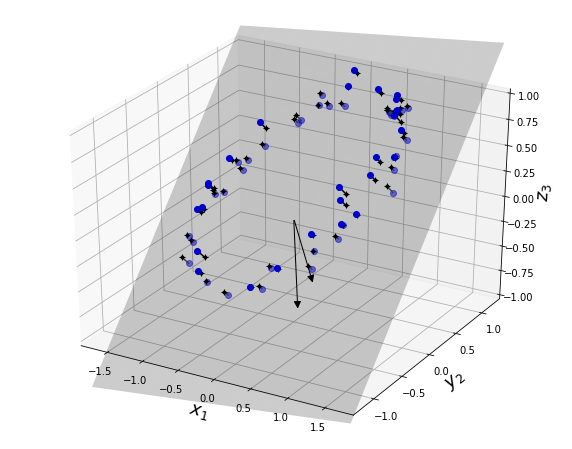

In [23]:
# Plot the dataset, the plane and the projection on that plane.
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:,2] > X3D_inv[:,2]]
X3D_below = X[X[:,2] <= X3D_inv[:,2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], 'bo', alpha=0.5)

ax.plot_surface(x1,x2,z, alpha=0.2, color='k')
np.linalg.norm(C, axis=0)

ax.add_artist(Arrow3D([0,C[1,0]],[0,C[0,1]],[0,C[0,2]], mutation_scale=15,lw=1,arrowstyle='-|>',color='k'))
ax.add_artist(Arrow3D([0,C[1,0]],[0,C[1,1]],[0,C[1,2]], mutation_scale=15, lw=1,arrowstyle='-|>',color='k'))
ax.plot([0],[0],[0], 'k')

for i in range(m):
    if X[i,2] > X3D_inv[i,2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]],[X[i][2], X3D_inv[i][2]],'k')
    else:
        ax.plot([X[i][0],X3D_inv[i][0]], [X[i][1],X3D_inv[i][1]], [X[i][2],X3D_inv[i][2]],'k-',color='#505050')
        
ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], 'k+')
ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2],'k.')
ax.plot(X3D_above[:,0], X3D_above[:,1], X3D_above[:,2], 'bo')

ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$y_2$", fontsize=18)
ax.set_zlabel("$z_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

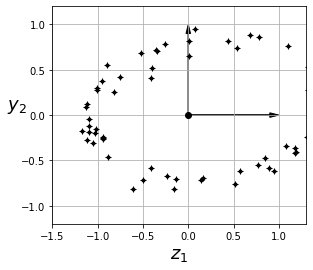

In [24]:
fig= plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:,0], X2D[:,1], "k+")
ax.plot(X2D[:,0], X2D[:,1], "k.")
ax.plot([0],[0],"ko")

ax.arrow(0,0,0,1, head_width = 0.05, length_includes_head=True, head_length=0.1, fc='k',ec='k')
ax.arrow(0,0,1,0, head_width = 0.05, length_includes_head=True, head_length=0.1,fc='k',ec='k')
ax.set_xlabel("$z_1$",fontsize=18)
ax.set_ylabel("$y_2$", fontsize=18, rotation=0)
ax.axis([-1.5,1.3,-1.2,1.2])
ax.grid(True)

# Manifold Learning
- 2D manifold is a 2D shape that can be bent and twisted in higher- dimensional space.
- Hypothesis - most real high dimensional datasets lie close to a much lower-dimensional manifold.
- Swiss roll

In [25]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

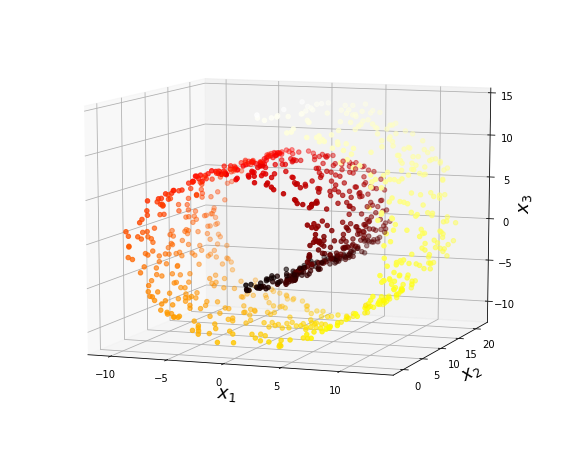

In [26]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10,-70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

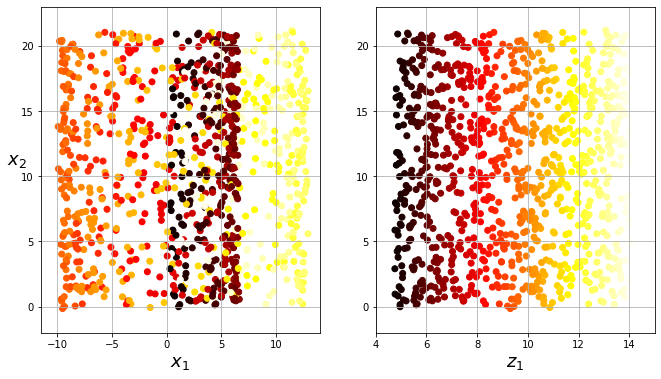

In [27]:
plt.figure(figsize=(11, 6))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

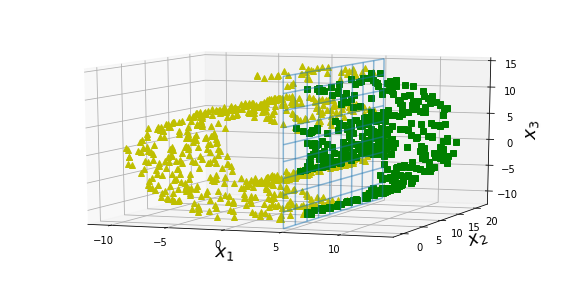

In [28]:
from matplotlib import gridspec

axes = [-11.5,14, -2,23, -12,15]

x2s = np.linspace(axes[2],axes[3],10)
x3s = np.linspace(axes[4],axes[5],10)
x2,x3 = np.meshgrid(x2s,x3s)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:,0]>5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10,-70)

ax.plot(X_neg[:,0], X_neg[:,1],X_neg[:,2], "y^")
ax.plot(X_pos[:,0],X_pos[:,1],X_pos[:,2],"gs")
ax.plot_wireframe(5,x2,x3,alpha=0.5)

ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

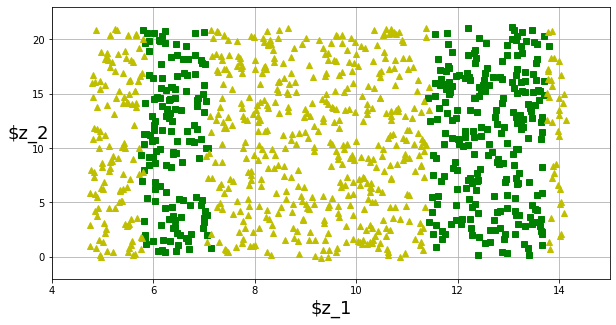

In [29]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4,15, axes[2], axes[3]])
plt.xlabel("$z_1", fontsize=18)
plt.ylabel("$z_2", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

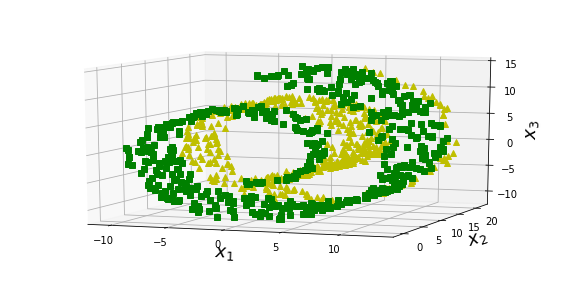

In [30]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection="3d")

positive_class = 2 * (t[:] - 4) > X[:,1]
X_pos = X[positive_class]
X_neg = X[~positive_class]

ax.view_init(10, -70)
ax.plot(X_neg[:,0], X_neg[:,1], X_neg[:,2],"y^")
ax.plot(X_pos[:,0],X_pos[:,1],X_pos[:,2],"gs")

ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

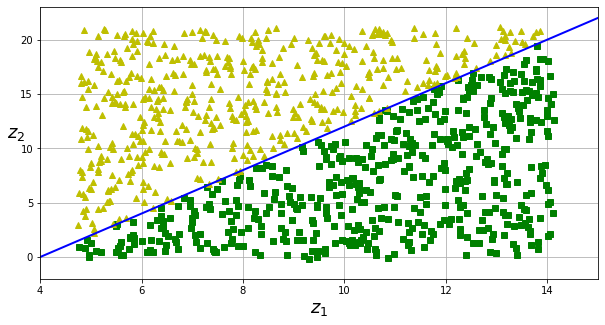

In [31]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class,1], "gs")
plt.plot(t[~positive_class], X[~positive_class,1],"y^")
plt.plot([4,15], [0,22], "b-", linewidth=2)
plt.axis([4,15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# PCA

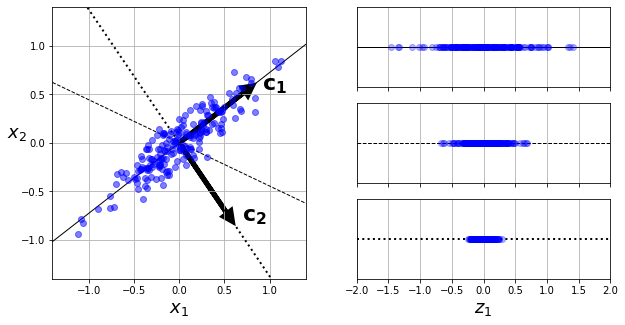

In [32]:
#It's always good to preserve the axis with the maximun amount pf variance.
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

#Plt.subplot2grid(shape, location, rowspan, colspan)
plt.figure(figsize=(10,5))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)

plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

# MNIST Compression

In [33]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [34]:
from sklearn.model_selection import train_test_split

X = mnist["data"] 
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [35]:
#Threshold created
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)+1

In [36]:
d 

154

In [37]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.components_

array([[ 8.93872316e-19,  1.11022302e-16, -1.11022302e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.51328542e-20, -5.37764278e-17,  4.33680869e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.94747555e-19, -1.38777878e-16, -5.89805982e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.03214341e-17,  2.28983499e-16, -1.52655666e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.38766842e-19, -1.32272665e-16, -4.05925293e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 2.57129007e-18,  1.56125113e-16,  2.30718222e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

In [52]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295708

In [53]:
#Reconstruction error which helps recreate the same data as before.
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [61]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    
    n_rows = (len(instances) - 1) //images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mp.cm.binary, **options)
    plt.axis("off")

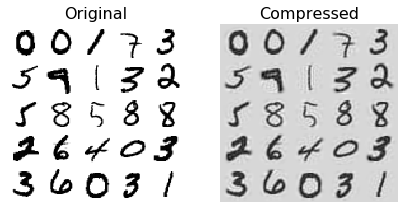

In [62]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

In [63]:
X_reduced_pca = X_reduced

# Incremental PCA

In [64]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [65]:
X_reduced_inc_pca = inc_pca.inverse_transform(X_reduced)

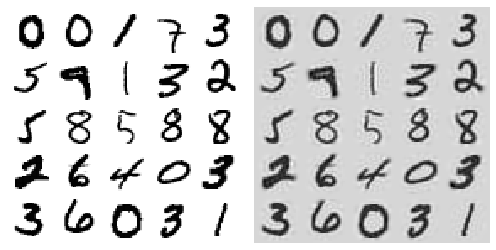

In [67]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_reduced_inc_pca[::2100])
plt.tight_layout()

In [68]:
X_reduced_inc_pca = X_reduced

In [69]:
# Compare results of transforming MNIST using regular PCA and incremental PCA
#First, the means are equal:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [70]:
#Results are not exaclty identical. incremental PCA gives a very good approximation.
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

# Using Memmap()
- Let's create the memmap() structure and copy the MNIST data into it 

In [71]:
filename = 'my_mnist.data'
m,n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m,n))
X_mm[:] = X_train

In [72]:
# This ensures the data is saved to the disk
del X_mm

In [73]:
#Loading data with another program and then use it to train
X_mm = np.memmap(filename,dtype='float32', mode='readonly', shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [74]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Time Complexity
- Let's time RegularPCA agst IncrementalPCA and RandomizedPCA for various numnber of principal components

In [75]:
import time

for n_components in (2,10,154):
    print("n_components = ", n_components)
    regular_pca = PCA(n_components)
    inc_pca = IncrementalPCA(n_components=n_components,batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver='randomized')
    
    for pca in (regular_pca,inc_pca,rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__,t2-t1))
        

n_components =  2
    PCA: 1.9 seconds
    IncrementalPCA: 15.2 seconds
    PCA: 1.9 seconds
n_components =  10
    PCA: 2.3 seconds
    IncrementalPCA: 15.6 seconds
    PCA: 2.1 seconds
n_components =  154
    PCA: 7.4 seconds
    IncrementalPCA: 25.0 seconds
    PCA: 6.9 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity')

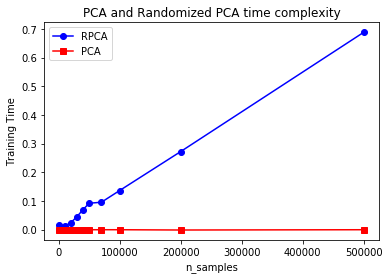

In [79]:
#Comparing PCA and Randomized PCA for datasets of different sizes(number of instances)

times_rpca = []
times_pca = []

sizes = [1000, 10000, 20000, 30000,40000,50000,70000,100000,200000,500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver='randomized', random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2-t1)
    pca = PCA(n_components=2)
    t1 = time.time()
    pca.fit(X)
    times_pca.append(t2-t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca,"r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training Time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity')

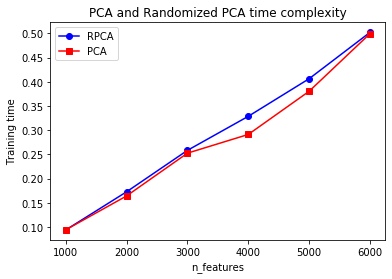

In [82]:
# Comparing performance on datasets of 2000 instances with various number of features

times_rpca=[]
times_pca=[]
sizes = [1000,2000,3000,4000,5000,6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42,svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2-t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2-t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity")

# Kernel PCA

In [84]:
X,t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


In [86]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

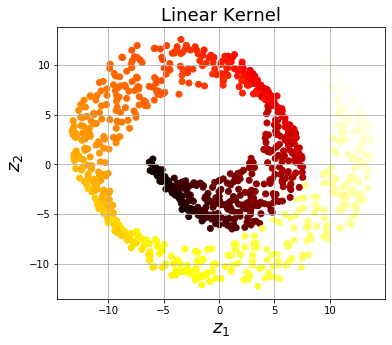

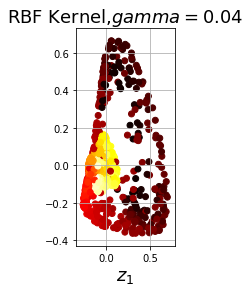

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


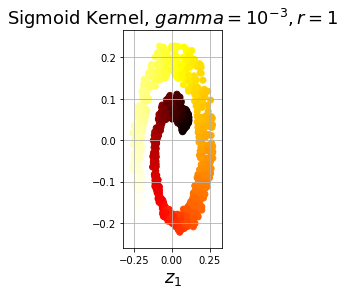

In [90]:
# fit_inverse_transform helps with the reconstruction error
# coef0 is the intercept used in SVM and Sigmoid
lin_pca = KernelPCA(n_components = 2,kernel='linear',fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel='rbf',gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(20,5))
for subplot, pca, title in ((131, lin_pca,'Linear Kernel'),(132, rbf_pca,'RBF Kernel,$gamma=0.04$'), 
                           (133, sig_pca,'Sigmoid Kernel, $gamma=10^{-3},r=1$')):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    plt.title(title, fontsize=18)
    plt.scatter(X_reduced[:,0],X_reduced[:,1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$",fontsize=18)
    plt.grid(True)
    plt.show()

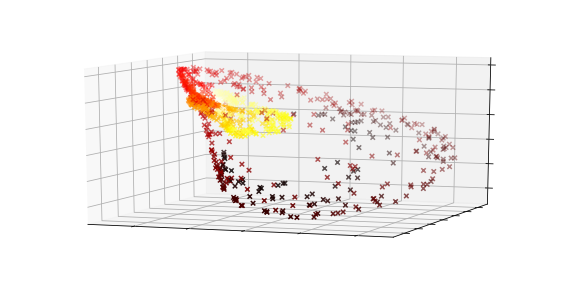

In [91]:
plt.figure(figsize=(10, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

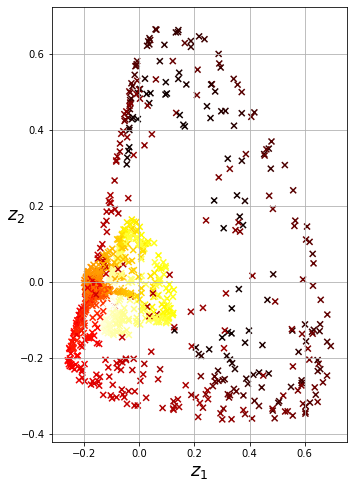

In [94]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(18, 8))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression(solver='liblinear'))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03,0.05,10),
    'kpca__kernel':['rbf','sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [101]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [103]:
rbf_pca = KernelPCA(n_components = 2, kernel='rbf',gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [104]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X,X_preimage)

32.78630879576611

# Locally Linear Embedding aka LLE

In [105]:
# Measures how each training instance is linearly related to its closest neighbors.
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [107]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

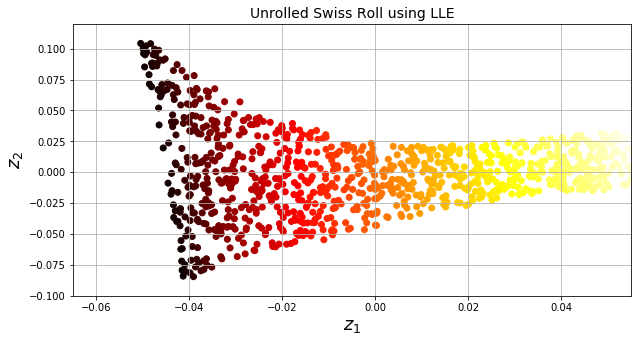

In [111]:
plt.figure(figsize=(10,5))
plt.title("Unrolled Swiss Roll using LLE",fontsize=14)
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065,0.055, -0.1,0.12])
plt.grid(True)
plt.show()

# Multidimensional Scaling - MDS, Isomap,  t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [113]:
# reduces dimensionality while trying to preserve the distances between the instances.
from sklearn.manifold import MDS

mds = MDS(n_components =  2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [115]:
# Isomap creates a graph by connecting each instance to its nearest neighbors.
from sklearn.manifold import Isomap

isomap = Isomap(n_components = 2)
X_reduced_isomap = isomap.fit_transform(X)

In [116]:
# reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.
from sklearn.manifold import TSNE

tsne =TSNE(n_components = 2, random_state = 42)
X_reduced_tsne = tsne.fit_transform(X)

In [119]:
# keep classes as far apart as possible and its a good method to be used before a classification algorithm. 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda =lda.transform(X_mnist)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


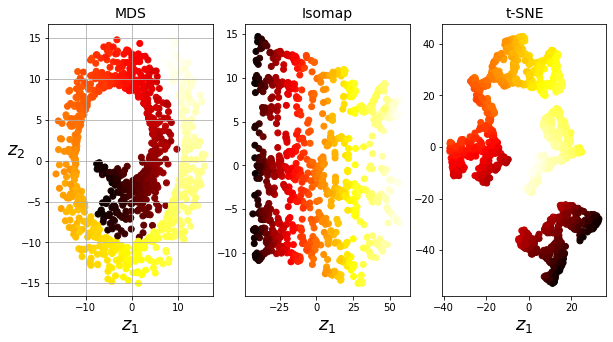

In [122]:
titles = [ 'MDS', 'Isomap','t-SNE']

plt.figure(figsize=(10,5))
for subplot, title, X_reduced in zip((131,132,133), titles, (X_reduced_mds,
                                    X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:,0],X_reduced[:,1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
        plt.grid(True)
plt.show()